# IPAN - ImageJ Processing Assistant Notebook

## 05 - CTCF Measurements
**Measure the Corrected Total Cell Fluorescence**

***
### Import Libraries and packages used from the notebook

In [1]:
import scyjava
from scyjava import jimport
from IPython.display import Image 

import os
from os.path import expanduser
import numpy as np

In [2]:
#Import libraries for dataframe management and visualization - settings
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = True)
plt.rc('font', family = 'times')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 16) 
plt.rc('figure', figsize = (12, 5))
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.serif": ["Palatino"]})

***
## CTCF Measurement
Use Macro to define the region covered by the cell and measure the fluorescence intensity. In this picture the cells are frequently overlapping, it is so difficult to define the border of each cell and to compute the CTCF/cell. What we can do is quantify the CFCT for each image and then divide it for the number of cells present in the image. We need to normalize this value because multiple overlapping cells may modify the intensity value without affecting the area value. To do that we can: quantify the CTCF on the GFP channels and quantify the nuclei on the DAPI channel. Let's deal with this problem by solving separate steps.

#### 1 - Run the Macro

Let's then run the Macro for each folder (sample) of the main folder. In this case, the macro is too complex to be run from the jupyter notebook. The resulted files are generated by using the CTCF.measurements.ijm macro from ImageJ.

#### 2 - Select the folder
Inser the path of the folder that contains the image. A new directory named "Results" will be created to store all the results. Then select the file under analysis.

In [3]:
EXPERIMENT_FOLDER = "/Users/nicolascristini/IPAN-Project/IPAN/CASES/CTCF_Case1"

For this CASE we are going to work with series of folders. Each folder represent one sample/condition for which multiple images have been acquired. The samples will be compared based on the average and standard deviation computed from the single images. 

In [4]:
folder_list = [f for f in os.listdir(EXPERIMENT_FOLDER) if not (f.startswith(".") or f.startswith("_"))] #TO avoid system or working filesfiles.
folder_list.sort()
print("The list of samples under analysis:\n\n", folder_list)

The list of samples under analysis:

 ['1-CTRL', '2-CTRLLTX', '3-DRUG_A', '4-DRUG_B']


#### 2 - Opload the result files.

In [5]:
#Create a dictionary to store multiple dataframe from one cycle
DATA_COL = {}

#Import DATA
for sample_folder in folder_list:
    print("Import Data of: ", sample_folder)
    filepath = EXPERIMENT_FOLDER + "/" + sample_folder + "/Results/Data.csv"
    DATA_COL[sample_folder] = pd.read_csv(filepath, header = 0, sep=',', encoding='latin-1', index_col=0)


print("\nExample:\n")
DATA_COL["1-CTRL"]
 #We can easily perform basic statiscs on the data

Import Data of:  1-CTRL
Import Data of:  2-CTRLLTX
Import Data of:  3-DRUG_A
Import Data of:  4-DRUG_B

Example:



,Nuclei,Signal-Area,Signal-Intensity,IntDen,Background-Area,Background-Intensity
Filename,,,,,,
1,90,101312,13.9515,1413456,307189,2.5400
2,63,73611,20.9297,1540655,348479,2.0226
3,63,79632,15.3730,1224181,339965,1.4102


Now that all the data have been uploaded to the notebook we can perform the calculations to define the average CTCF of each image. The following step is to gather all the files in one single data frame, compute average and standard deviation and plot it to the screen.

#### 3 - Calculate the CTCF on each dataframe and collect the results
CTCF = Integrated Density – (Area of selected cell * Mean fluorescence of background readings)

In [6]:
for dataset in DATA_COL.keys():
    DATA_COL[dataset]["CTCF"] = DATA_COL[dataset]["IntDen"] - (DATA_COL[dataset]["Signal-Area"] * DATA_COL[dataset]["Background-Intensity"])
    DATA_COL[dataset]["CTCF/cell"] = DATA_COL[dataset]["CTCF"] / DATA_COL[dataset]["Nuclei"]

In [7]:
#Each dataset look like this. Example:
DATA_COL["1-CTRL"]

,Nuclei,Signal-Area,Signal-Intensity,IntDen,Background-Area,Background-Intensity,CTCF,CTCF/cell
Filename,,,,,,,,
1,90,101312,13.9515,1413456,307189,2.5400,1.156124e+06,12845.816889
2,63,73611,20.9297,1540655,348479,2.0226,1.391769e+06,22091.577641
3,63,79632,15.3730,1224181,339965,1.4102,1.111884e+06,17648.951644


In [8]:
#We can now compute the sample-average and the sd of create a new dataframe.
DATA_RESULTS = {}
for dataset in DATA_COL.keys():
    DATA_RESULTS[dataset] = [DATA_COL[dataset]["CTCF/cell"].mean(), DATA_COL[dataset]["CTCF/cell"].std()]
DATA_RESULTS

{'1-CTRL': [17528.782058201057, 4624.051634623087],
 '2-CTRLLTX': [15242.397644298102, 801.2264235757327],
 '3-DRUG_A': [15075.51173126984, 1422.5361973145382],
 '4-DRUG_B': [7428.4428987529545, 2366.272254911257]}

In [9]:
DATA_RESULTS_FRAME = pd.DataFrame.from_dict(DATA_RESULTS, orient = "Index", columns= ["Mean", "Std"]) 
DATA_RESULTS_FRAME

,Mean,Std
1-CTRL,17528.782058,4624.051635
2-CTRLLTX,15242.397644,801.226424
3-DRUG_A,15075.511731,1422.536197
4-DRUG_B,7428.442899,2366.272255


#### 4 - Create folder to save images

In [10]:
EXPERIMENT_FOLDER

'/Users/nicolascristini/IPAN-Project/IPAN/CASES/CTCF_Case1'

In [11]:
plotdir = EXPERIMENT_FOLDER + "/" "_Plots"
try:
    os.mkdir(plotdir)
    print("Output directory created")
except FileExistsError:
        print("Output directory already exist.")

Output directory already exist.


#### 5 - Plot the descriptive of the data in a bar plot

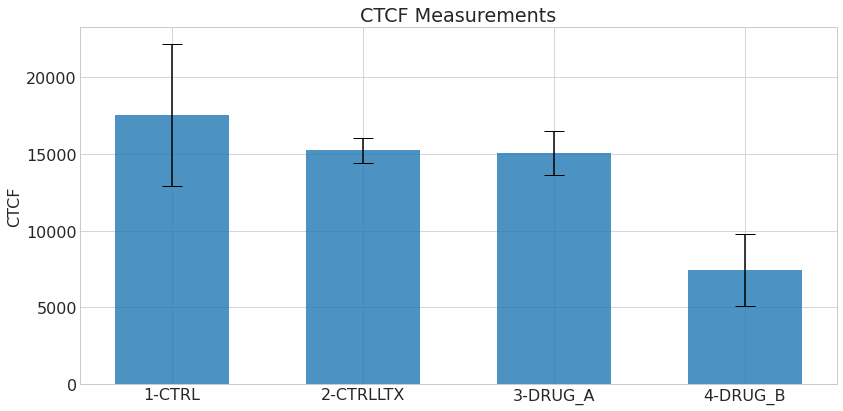

In [12]:
#Creates list for the plot
samples = DATA_RESULTS_FRAME.index.to_list()
x_pos = np.arange(len(samples))

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x_pos, DATA_RESULTS_FRAME["Mean"], yerr=DATA_RESULTS_FRAME["Std"], align='center', alpha=0.8, ecolor='black', capsize=10, width=0.6)
ax.set_ylabel('CTCF')
ax.set_xticks(x_pos)
ax.set_xticklabels(samples)
ax.set_title('CTCF Measurements')
ax.yaxis.grid(True)
plt.tick_params(labelsize=16)

# Save and show the figure
plt.savefig(plotdir + '/CTCF Measurements.png')

plt.tight_layout()
plt.show()

***
***